# 2D Gaussians problem setting

Visualizing the difference between unsupervised and semi-supervised subspace alignment.

In [1]:
import numpy as np
import numpy.random as rnd
import scipy.stats as st
import scipy.linalg as alg

In [2]:
import sys
sys.path.append("..")
from subalign import SubspaceAlignedClassifier, SemiSubspaceAlignedClassifier

In [3]:
%matplotlib inline
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
sns.set(style="whitegrid")

fS = 24
figS2 = (10,5)
figS3 = (15,5)
xlims = [-8,8]
ylims = [-8,8]
font = {'weight' : 'bold', 'size'   : fS}
matplotlib.rc('font', **font)

alphav = 0.2
clrs = ['r', 'b']

In [71]:
'''Generate data'''

# Dimensionality
D = 2

# Subspace dim
d = 2

# Number of classes
K = 2

# Sample sizes
N = 20
N0 = 16
N1 = N - N0
M = 20
M0 = 16
M1 = M - M0

# Number of target labels
Mu = 3

muS0 = np.array([-2, -1])
muS1 = np.array([2, 1])
muT0 = np.array([1, 2])
muT1 = np.array([-1, -1])
SiS0 = np.array([[3, 0.4],[0.4, 1.5]])
SiS1 = np.array([[1.2, 0.1],[0.1, 0.9]])
SiT0 = np.array([[2, 0.2],[0.2, 1]])
SiT1 = np.array([[1.2, 0.5],[0.5, 1.8]])

pS0 = st.multivariate_normal(muS0, SiS0)
pS1 = st.multivariate_normal(muS1, SiS1)
pT0 = st.multivariate_normal(muT0, SiT0)
pT1 = st.multivariate_normal(muT1, SiT1)

X = np.concatenate((pS0.rvs(N0), pS1.rvs(N1)), axis=0)
Y = np.concatenate((np.zeros((N0,)), np.ones(N1,)), axis=0)

Z = np.concatenate((pT0.rvs(M0), pT1.rvs(M1)), axis=0)
U = np.concatenate((np.zeros((M0,)), np.ones(M1,)), axis=0)
    
# Z-score data
# X = st.zscore(X)
# Z = st.zscore(Z)

In [72]:
'''Select target samples to be labeled'''

u = np.zeros((K*Mu, 2), dtype='uint8')
u_ = np.zeros((M, K), dtype='bool')

for k in range(K):

    # Subsample
    ix = rnd.choice(np.arange(M), size=Mu, p=(U==k)/np.sum(U==k))
    
    # Index array
    u[k*Mu:(k+1)*Mu, 0] = ix
    u[k*Mu:(k+1)*Mu, 1] = k
    
    # Boolean version
    u_[ix, k] = True
                

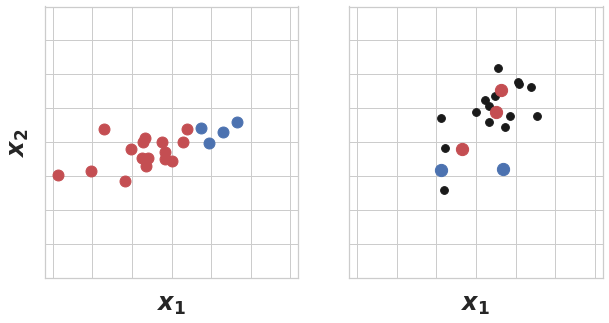

In [73]:
'''Visualize problem setting'''

fig = plt.figure(figsize=figS2)        
    
ax0 = fig.add_subplot(121)

ax0.set_xlim(xlims)
ax0.set_ylim(ylims)

ax0.scatter(X[Y == 0, 0], X[Y == 0, 1], c='r', s=120)
ax0.scatter(X[Y == 1, 0], X[Y == 1, 1], c='b', s=120)
ax0.set_xlabel('$x_1$', fontsize=fS)
ax0.set_ylabel('$x_2$', fontsize=fS)

ax1 = fig.add_subplot(122, sharex=ax0, sharey=ax0)
ax1.scatter(Z[:, 0], Z[:, 1], c='k', s=60)
for k in range(K):
    ax1.scatter(Z[u_[:,k], 0], Z[u_[:,k], 1], c=clrs[k], s=150)
ax1.set_xlabel('$x_1$', fontsize=fS)
ax1.set_xticklabels(labels='')
ax1.set_yticklabels(labels='')
    
fig.savefig('viz/2DG_problem-setting.png', bbox_inches='tight', padding=None)
fig.savefig('viz/2DG_problem-setting.eps', bbox_inches='tight', padding=None)

In [74]:
'''Find principal components'''

# Domain means
muX = np.mean(X, axis=0)[:, np.newaxis].T
muZ = np.mean(Z, axis=0)[:, np.newaxis].T

# Centered data
X_ = X - muX
Z_ = Z - muZ

# Estimate principal components manually
aX, CX = alg.eig(np.cov(X_.T))
aZ, CZ = alg.eig(np.cov(Z_.T))

# Sort components on decreasing eigenvalues
ixX = np.argsort(aX)[::-1]
# CX = CX[ixX,:]
ixZ = np.argsort(aZ)[::-1]
# CZ = CZ[ixZ,:]

In [75]:
'''Process target data'''

# Map target data onto total target components
ZC = Z @ CZ

# Map source data onto total source components
XC = X @ CX

In [76]:
'''Unsupervised alignment'''

# Optimal linear transformation matrix
W = CX.T @ CZ

# Map source data onto source principal components and align to target components
XW = X @ CX @ W

In [77]:
'''Semi-supervised alignment'''

# Call instance of subalign
clf = SemiSubspaceAlignedClassifier()

# Obtain transformation matrix and components
V, CX, _ = clf.semi_subspace_alignment(X, Y, Z, u, subspace_dim=d)

XV = np.zeros((N, d))

# Align each class
for k in range(K):
    
    # Class means
    muXk = np.mean(X[Y == k, :], axis=0)
    muZk = np.mean(ZC[u_[:,k], :], axis=0, keepdims=1)
    
    # Map source data onto source principal components and align to target components
    XV[Y == k, :] = (X[Y == k, :] - muXk) @ CX[k] @ V[k] + muZk

Final regularization parameter = 1e-06
Final regularization parameter = 1e-06
Final regularization parameter = 1e-06
Final regularization parameter = 1e-06
Final regularization parameter = 1e-06


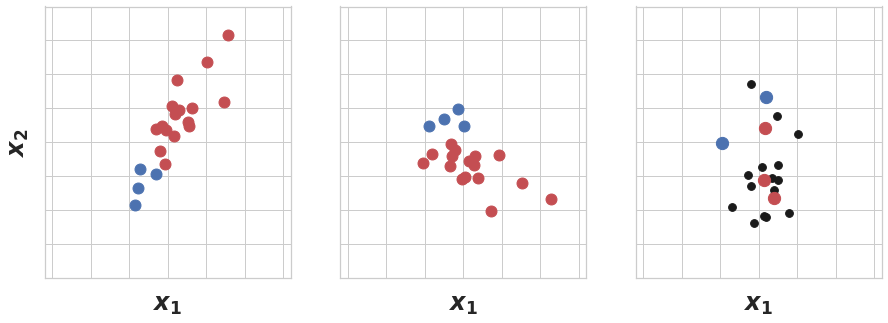

In [78]:
'''Visualize data'''

fig, ax = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=figS3)

ax[0].set_xlim(xlims)
ax[0].set_ylim(ylims)

XV0 = XV[Y == 0, :]
XV1 = XV[Y == 1, :]

# Plot unsupervised alignment
ax[0].scatter(XW[Y == 0, 0], XW[Y == 0, 1], c='r', s=120)
ax[0].scatter(XW[Y == 1, 0], XW[Y == 1, 1], c='b', s=120)
ax[0].set_xlabel('$x_1$', fontsize=fS)
ax[0].set_ylabel('$x_2$', fontsize=fS)
ax[0].set_xticklabels(labels='')
ax[0].set_yticklabels(labels='')

# Plot semi-supervised alignment
ax[1].scatter(XV0[:, 0], XV0[:, 1], c='r', s=120)
ax[1].scatter(XV1[:, 0], XV1[:, 1], c='b', s=120)
ax[1].set_xlabel('$x_1$', fontsize=fS)
ax[1].set_xticklabels(labels='')
ax[1].set_yticklabels(labels='')

# Plot target data
ax[2].scatter(ZC[:, 0], ZC[:, 1], c='k', s=60)
for k in range(K):
    ax[2].scatter(ZC[u_[:,k], 0], ZC[u_[:,k], 1], c=clrs[k], s=150)
ax[2].set_xlabel('$x_1$', fontsize=fS)
ax[2].set_xticklabels(labels='')
ax[2].set_yticklabels(labels='')

fig.savefig('viz/2DG_subalign.png', bbox_inches='tight', padding=None)
fig.savefig('viz/2DG_subalign.eps', bbox_inches='tight', padding=None)

## Add error ellipses to distributions to better visualize rotations and translations in space

In [79]:
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

In [80]:
def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of `x` and `y`

    Parameters
    ----------
    x, y : array_like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    Returns
    -------
    matplotlib.patches.Ellipse

    Other parameters
    ----------------
    kwargs : `~matplotlib.patches.Patch` properties
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0),
        width=ell_radius_x * 2,
        height=ell_radius_y * 2,
        facecolor=facecolor,
        **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

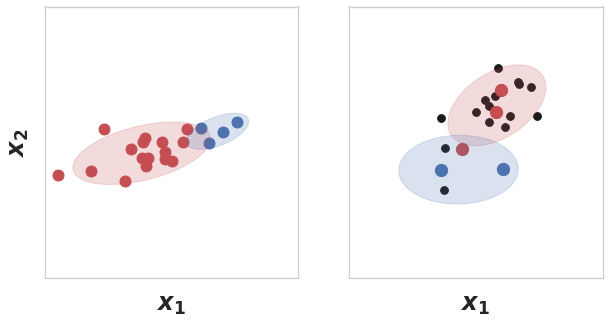

In [81]:
'''Visualize problem setting'''

fig = plt.figure(figsize=figS2)        
    
ax0 = fig.add_subplot(121)

ax0.set_xlim(xlims)
ax0.set_ylim(ylims)

confidence_ellipse(X[Y == 0, 0], X[Y == 0, 1], ax0, n_std=2.0, facecolor='r', edgecolor='r', alpha=alphav)
confidence_ellipse(X[Y == 1, 0], X[Y == 1, 1], ax0, n_std=2.0, facecolor='b', edgecolor='b', alpha=alphav)
ax0.scatter(X[Y == 0, 0], X[Y == 0, 1], c='r', s=120)
ax0.scatter(X[Y == 1, 0], X[Y == 1, 1], c='b', s=120)

ax0.set_xlabel('$x_1$', fontsize=fS)
ax0.set_ylabel('$x_2$', fontsize=fS)
ax0.grid(False)

ax1 = fig.add_subplot(122, sharex=ax0, sharey=ax0)
ax1.scatter(Z[:, 0], Z[:, 1], c='k', s=60)
for k in range(K):
    confidence_ellipse(Z[U == k, 0], Z[U == k, 1], ax1, n_std=2.0, facecolor=clrs[k], edgecolor=clrs[k], alpha=alphav)
    ax1.scatter(Z[u_[:,k], 0], Z[u_[:,k], 1], c=clrs[k], s=150)
    
ax1.set_xlabel('$x_1$', fontsize=fS)
ax1.set_xticklabels(labels='')
ax1.set_yticklabels(labels='')
ax1.grid(False)
    
fig.savefig('viz/2DG_problem-setting_error-ellipses.png', bbox_inches='tight', padding=None)
# fig.savefig('viz/2DG_problem-setting_error-ellipses.eps', bbox_inches='tight', padding=None)
fig.savefig('viz/2DG_problem-setting_error-ellipses.pdf', bbox_inches='tight', padding=None)

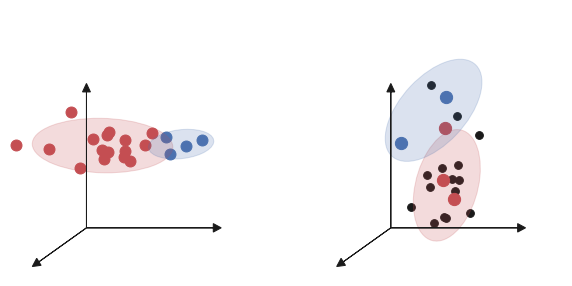

In [82]:
'''Visualize problem setting'''

fig = plt.figure(figsize=figS2)        
    
ax0 = fig.add_subplot(121)

ax0.set_xlim(xlims)
ax0.set_ylim(ylims)

confidence_ellipse(XC[Y == 0, 0], XC[Y == 0, 1], ax0, n_std=2.0, facecolor='r', edgecolor='r', alpha=alphav)
confidence_ellipse(XC[Y == 1, 0], XC[Y == 1, 1], ax0, n_std=2.0, facecolor='b', edgecolor='b', alpha=alphav)
ax0.scatter(XC[Y == 0, 0], XC[Y == 0, 1], c='r', s=120)
ax0.scatter(XC[Y == 1, 0], XC[Y == 1, 1], c='b', s=120)

# ax0.set_xlabel('$x_1$', fontsize=fS)
# ax0.set_ylabel('$x_2$', fontsize=fS)
ax0.grid(False)
ax0.spines["left"].set_visible(False)
ax0.spines["right"].set_visible(False)
ax0.spines["top"].set_visible(False)
ax0.spines["bottom"].set_visible(False)
ax0.arrow(-3,-5,0,8, fc="k", ec="k", head_width=0.5, head_length=0.5)
ax0.arrow(-3,-5,-3,-2, fc="k", ec="k", head_width=0.5, head_length=0.5)
ax0.arrow(-3,-5,8,0, fc="k", ec="k", head_width=0.5, head_length=0.5)

ax1 = fig.add_subplot(122, sharex=ax0, sharey=ax0)
ax1.scatter(ZC[:, 0], ZC[:, 1], c='k', s=60)
for k in range(K):
    confidence_ellipse(ZC[U == k, 0], ZC[U == k, 1], ax1, n_std=2.0, facecolor=clrs[k], edgecolor=clrs[k], alpha=alphav)
    ax1.scatter(ZC[u_[:,k], 0], ZC[u_[:,k], 1], c=clrs[k], s=150)
    
# ax1.set_xlabel('$x_1$', fontsize=fS)
ax1.set_xticklabels(labels='')
ax1.set_yticklabels(labels='')
ax1.grid(False)
ax1.spines["left"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax1.spines["top"].set_visible(False)
ax1.spines["bottom"].set_visible(False)
ax1.arrow(-3,-5,0,8, fc="k", ec="k", head_width=0.5, head_length=0.5)
ax1.arrow(-3,-5,-3,-2, fc="k", ec="k", head_width=0.5, head_length=0.5)
ax1.arrow(-3,-5,8,0, fc="k", ec="k", head_width=0.5, head_length=0.5)
    
fig.savefig('viz/2DG_problem-setting_error-ellipses.png', bbox_inches='tight', padding=None)
# fig.savefig('viz/2DG_problem-setting_error-ellipses.eps', bbox_inches='tight', padding=None)
fig.savefig('viz/2DG_problem-setting_error-ellipses.pdf', bbox_inches='tight', padding=None)

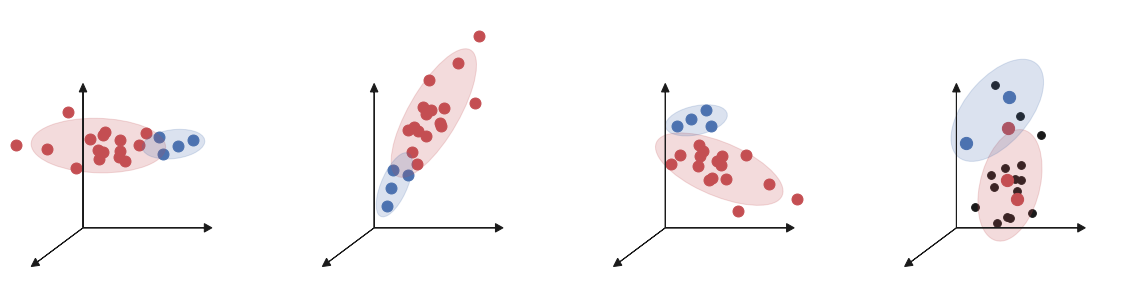

In [83]:
'''Visualize data'''

fig, ax = plt.subplots(ncols=4, sharex=True, sharey=True, figsize=(20,5))

ax[0].set_xlim(xlims)
ax[0].set_ylim(ylims)

XV0 = XV[Y == 0, :]
XV1 = XV[Y == 1, :]

# Plot unsupervised alignment
confidence_ellipse(XC[Y == 0, 0], XC[Y == 0, 1], ax[0], n_std=2.0, facecolor='r', edgecolor='r', alpha=alphav)
confidence_ellipse(XC[Y == 1, 0], XC[Y == 1, 1], ax[0], n_std=2.0, facecolor='b', edgecolor='b', alpha=alphav)
ax[0].scatter(XC[Y == 0, 0], XC[Y == 0, 1], c='r', s=120)
ax[0].scatter(XC[Y == 1, 0], XC[Y == 1, 1], c='b', s=120)

# ax[0].set_xlabel('$x_1$', fontsize=fS)
# ax[0].set_ylabel('$x_2$', fontsize=fS)
ax[0].set_xticklabels(labels='')
ax[0].set_yticklabels(labels='')
ax[0].grid(False)
ax[0].spines["left"].set_visible(False)
ax[0].spines["right"].set_visible(False)
ax[0].spines["top"].set_visible(False)
ax[0].spines["bottom"].set_visible(False)
ax[0].arrow(-3,-5,0,8, fc="k", ec="k", head_width=0.5, head_length=0.5)
ax[0].arrow(-3,-5,-3,-2, fc="k", ec="k", head_width=0.5, head_length=0.5)
ax[0].arrow(-3,-5,8,0, fc="k", ec="k", head_width=0.5, head_length=0.5)

# Plot unsupervised alignment
confidence_ellipse(XW[Y == 0, 0], XW[Y == 0, 1], ax[1], n_std=2.0, facecolor='r', edgecolor='r', alpha=alphav)
confidence_ellipse(XW[Y == 1, 0], XW[Y == 1, 1], ax[1], n_std=2.0, facecolor='b', edgecolor='b', alpha=alphav)
ax[1].scatter(XW[Y == 0, 0], XW[Y == 0, 1], c='r', s=120)
ax[1].scatter(XW[Y == 1, 0], XW[Y == 1, 1], c='b', s=120)

# ax[1].set_xlabel('$x_1$', fontsize=fS)
# ax[1].set_ylabel('$x_2$', fontsize=fS)
ax[1].set_xticklabels(labels='')
ax[1].set_yticklabels(labels='')
ax[1].grid(False)
ax[1].spines["left"].set_visible(False)
ax[1].spines["right"].set_visible(False)
ax[1].spines["top"].set_visible(False)
ax[1].spines["bottom"].set_visible(False)
ax[1].arrow(-3,-5,0,8, fc="k", ec="k", head_width=0.5, head_length=0.5)
ax[1].arrow(-3,-5,-3,-2, fc="k", ec="k", head_width=0.5, head_length=0.5)
ax[1].arrow(-3,-5,8,0, fc="k", ec="k", head_width=0.5, head_length=0.5)

# Plot semi-supervised alignment
confidence_ellipse(XV0[:, 0], XV0[:, 1], ax[2], n_std=2.0, facecolor='r', edgecolor='r', alpha=alphav)
confidence_ellipse(XV1[:, 0], XV1[:, 1], ax[2], n_std=2.0, facecolor='b', edgecolor='b', alpha=alphav)
ax[2].scatter(XV0[:, 0], XV0[:, 1], c='r', s=120)
ax[2].scatter(XV1[:, 0], XV1[:, 1], c='b', s=120)

# ax[2].set_xlabel('$x_1$', fontsize=fS)
ax[2].set_xticklabels(labels='')
ax[2].set_yticklabels(labels='')
ax[2].grid(False)
ax[2].spines["left"].set_visible(False)
ax[2].spines["right"].set_visible(False)
ax[2].spines["top"].set_visible(False)
ax[2].spines["bottom"].set_visible(False)
ax[2].arrow(-3,-5,0,8, fc="k", ec="k", head_width=0.5, head_length=0.5)
ax[2].arrow(-3,-5,-3,-2, fc="k", ec="k", head_width=0.5, head_length=0.5)
ax[2].arrow(-3,-5,8,0, fc="k", ec="k", head_width=0.5, head_length=0.5)

# Plot target data
ax[3].scatter(ZC[:, 0], ZC[:, 1], c='k', s=60)
for k in range(K):
    confidence_ellipse(ZC[U == k, 0], ZC[U == k, 1], ax[3], n_std=2.0, facecolor=clrs[k], edgecolor=clrs[k], alpha=alphav)
    ax[3].scatter(ZC[u_[:,k], 0], ZC[u_[:,k], 1], c=clrs[k], s=150)
    

# ax[3].set_xlabel('$x_1$', fontsize=fS)
ax[3].set_xticklabels(labels='')
ax[3].set_yticklabels(labels='')
ax[3].grid(False)
ax[3].spines["left"].set_visible(False)
ax[3].spines["right"].set_visible(False)
ax[3].spines["top"].set_visible(False)
ax[3].spines["bottom"].set_visible(False)
ax[3].arrow(-3,-5,0,8, fc="k", ec="k", head_width=0.5, head_length=0.5)
ax[3].arrow(-3,-5,-3,-2, fc="k", ec="k", head_width=0.5, head_length=0.5)
ax[3].arrow(-3,-5,8,0, fc="k", ec="k", head_width=0.5, head_length=0.5)

fig.savefig('viz/2DG_subalign_error-ellips.png', bbox_inches='tight', padding=None)
# fig.savefig('viz/2DG_subalign_error-ellips.eps', bbox_inches='tight', padding=None)
fig.savefig('viz/2DG_subalign_error-ellips.pdf', bbox_inches='tight', padding=None)

## Adding text to points to provide better example for NLP

In [184]:
'''Text for in plots'''

words_S0 = ["model", "algorithm", "computer"]
words_S1 = ["Bert", "Elmo", "Ernie"]
words_T0 = ["BERT", "ELMo", "network"]
words_T1 = ["Johnson", "Juncker", "Tusk"]

In [189]:
import numpy.random as rnd

num_subset = 3

XC0 = XC[Y == 0, :]
XC1 = XC[Y == 1, :]

nX0 = XC0.shape[0]
nX1 = XC1.shape[0]
ix0 = rnd.choice(range(nX0), size=num_subset, replace=False)
ix1 = rnd.choice(range(nX1), size=num_subset, replace=False)
XC0 = XC0[ix0,:]
XC1 = XC1[ix1,:]

ZCu0 = ZC[u_[:,0], :]
ZCu1 = ZC[u_[:,1], :]

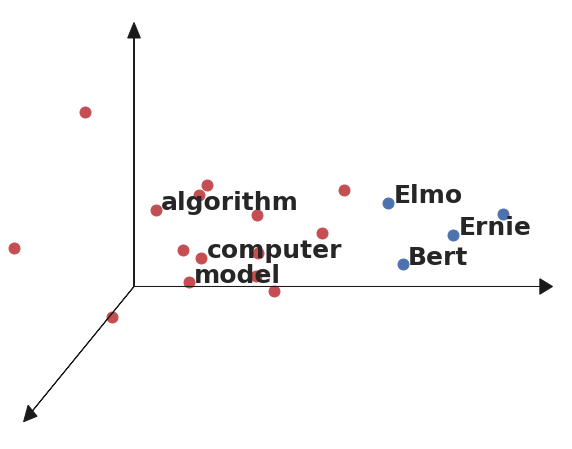

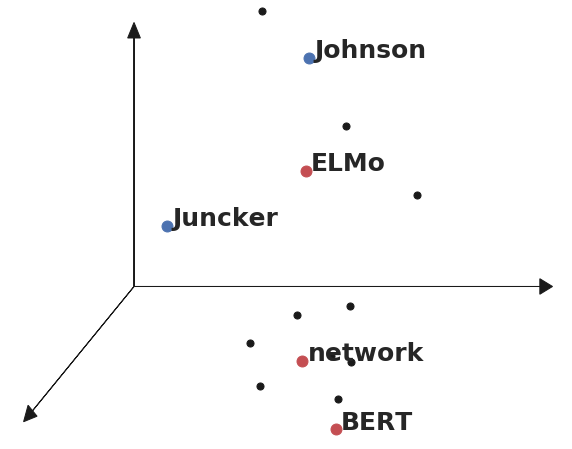

In [197]:
'''Visualize problem setting'''

fig = plt.figure(figsize=(10,8))        
ax0 = fig.add_subplot(111)
ax0.set_xlim([-5.5,5.5])
ax0.set_ylim([-3.5,3.5])

# confidence_ellipse(XC[Y == 0, 0], XC[Y == 0, 1], ax0, n_std=2.0, facecolor='r', edgecolor='r', alpha=alphav)
# confidence_ellipse(XC[Y == 1, 0], XC[Y == 1, 1], ax0, n_std=2.0, facecolor='b', edgecolor='b', alpha=alphav)
ax0.scatter(XC[Y==0, 0], XC[Y==0, 1], c='r', s=120)
ax0.scatter(XC[Y==1, 0], XC[Y==1, 1], c='b', s=120)
for ii in range(num_subset):
    ax0.text(XC0[ii,0]+0.1, XC0[ii,1], words_S0[ii], fontsize=25, fontweight='bold')
    ax0.text(XC1[ii,0]+0.1, XC1[ii,1], words_S1[ii], fontsize=25, fontweight='bold')

# ax0.set_xlabel('$x_1$', fontsize=fS)
# ax0.set_ylabel('$x_2$', fontsize=fS)
ax0.set_xticklabels(labels='')
ax0.set_yticklabels(labels='')
ax0.grid(False)
ax0.spines["left"].set_visible(False)
ax0.spines["right"].set_visible(False)
ax0.spines["top"].set_visible(False)
ax0.spines["bottom"].set_visible(False)
ax0.arrow(-3,-1,0, 4, fc="k", ec="k", head_width=0.25, head_length=0.25, alpha=1.)
ax0.arrow(-3,-1,-2,-2, fc="k", ec="k", head_width=0.25, head_length=0.25, alpha=1.)
ax0.arrow(-3,-1, 8,0, fc="k", ec="k", head_width=0.25, head_length=0.25, alpha=1.)

fig.savefig('viz/2DG_problem-setting-src_annotated.png', bbox_inches='tight', padding=None)
# fig.savefig('viz/2DG_problem-setting_error-ellipses.eps', bbox_inches='tight', padding=None)
fig.savefig('viz/2DG_problem-setting-src_annotated.pdf', bbox_inches='tight', padding=None)

fig = plt.figure(figsize=(10,8))        
ax1 = fig.add_subplot(111)
ax1.set_xlim([-5.5,5.5])
ax1.set_ylim([-3.5,3.5])

ax1.scatter(ZC[:, 0], ZC[:, 1], c='k', s=50)

# confidence_ellipse(ZC[U == 0, 0], ZC[U == 0, 1], ax1, n_std=2.0, facecolor=clrs[0], edgecolor=clrs[0], alpha=alphav)
# confidence_ellipse(ZC[U == 1, 0], ZC[U == 1, 1], ax1, n_std=2.0, facecolor=clrs[1], edgecolor=clrs[1], alpha=alphav)
ax1.scatter(ZC[u_[:,0], 0], ZC[u_[:,0], 1], c=clrs[0], s=120)
ax1.scatter(ZC[u_[:,1], 0], ZC[u_[:,1], 1], c=clrs[1], s=120)
for ii in range(len(ZCu0)):
    ax1.text(ZCu0[ii,0]+0.1, ZCu0[ii,1], words_T0[ii], fontsize=25, fontweight='bold')
for ii in range(len(ZCu1)):
    ax1.text(ZCu1[ii,0]+0.1, ZCu1[ii,1], words_T1[ii], fontsize=25, fontweight='bold')
    
# ax1.set_xlabel('$x_1$', fontsize=fS)
ax1.set_xticklabels(labels='')
ax1.set_yticklabels(labels='')
ax1.grid(False)
ax1.spines["left"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax1.spines["top"].set_visible(False)
ax1.spines["bottom"].set_visible(False)
ax1.arrow(-3,-1,0, 4, fc="k", ec="k", head_width=0.25, head_length=0.25, alpha=1.)
ax1.arrow(-3,-1,-2,-2, fc="k", ec="k", head_width=0.25, head_length=0.25, alpha=1.)
ax1.arrow(-3,-1, 8,0, fc="k", ec="k", head_width=0.25, head_length=0.25, alpha=1.)
    
fig.savefig('viz/2DG_problem-setting-tgt_annotated.png', bbox_inches='tight', padding=None)
# fig.savefig('viz/2DG_problem-setting_error-ellipses.eps', bbox_inches='tight', padding=None)
fig.savefig('viz/2DG_problem-setting-tgt_annotated.pdf', bbox_inches='tight', padding=None)